# Module 7, Numerical fitting applications: Estimating $H_0$ from Type Ia Supernovae
(Partially adapted from Landau 2015 Chapter 7 and course notes from AST 390: Computational Astrophysics by Michael Zingale, SUNY Stony Brook)

Time to apply our numerical fitting tools to a specific problem! In this project we'll be estimating the Hubble constant from Type Ia supernovae.  

Type Ia supernovae are often used as "Standard Candles" to measure cosmological distances.  By measuring how long it takes for the supernova to dim we can emperically determine its brightness via the [Phillips relation](https://en.wikipedia.org/wiki/Phillips_relationship). We will use data from the paper [_Spectra and Hubble Space Telescope Light Curves of Six Type Ia Supernovae at 0.511 < z < 1.12 and the Union2 Compilation_](https://ui.adsabs.harvard.edu/abs/2010ApJ...716..712A/abstract) by Amanullah et al. including ~ 500 Type Ia supernovae.

(Note: that paper does a more sophisticated analysis than what we are going to do, and they fit for other cosmological parameters as well, so we will not get the same answer as they do.)

The dataset **SCPUnion2_mu_vs_z.txt** in your working directory has 4 columns:
* supernova identifier
* redshift (dimensionless, fractional change in wavelength), $z$ 
* distance modulus (dimensionless), $\mu$
* uncertainty in $\mu$ (dimensionless)

<div class="span alert alert-success">

Read the data file **SCPUnion2_mu_vs_z.txt** and extract the columns for the redshift $z$ and the distance modulus $\mu$. If you are using np.loadtxt() you'll probably run into an error since the first column of the data is a bunch of text strings (which labels the supernovae). 
    
Try to find a workaround: for example, is there an optional argument in loadtxt() that allows ignoring columns? Or can we let loadtxt() know the formats of the data in each column?
    
Then let's plot the distance modulus $\mu$ vs redshift $z$.

The [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) of a supernova is related to its [luminosity distance](https://en.wikipedia.org/wiki/Luminosity_distance)  $d$ to earth by

$$\mu =  5 \log_{10} \left (\frac{d}{10~\mbox{pc}}\right )= 5 \log_{10} \left (\frac{d}{1~\mbox{Mpc}}\right ) + 25$$

In an expanding Universe, $d$ can be expressed via an expansion in redshift $z$, as (for $z \ll 1$):

$$d \approx \frac{c}{H_0} \left [ z + \frac{1}{2} (1 - q_0) z^2 + \ldots \right ]$$

Here $c$ is the speed of light, $H_0$ is the [Hubble constant](https://en.wikipedia.org/wiki/Hubble%27s_law), and $q_0$ is the [deceleration parameter](https://en.wikipedia.org/wiki/Deceleration_parameter). Therefore, if we can fit our $\mu$ versus $z$ data, we'll be able to estimate the Hubble constant $H_0$. Combining the two relations above, we want to fit:

$$\mu = 5\log_{10} \left (\frac{cz}{H_0 \cdot 1~\mbox{Mpc}} \left [1 + \frac{1}{2} (1 - q_0) z \right ] \right ) + 25$$

which we'll write as:

$$\mu = 5\log_{10} \left (a_0 z \left [1 + \frac{1}{2} (1 - a_1) z \right ] \right ) + 25$$

This is a nonlinear equation in terms of the fit parameters $a_0$ and $a_1$.  Once we get $a_0$, we can get the Hubble constant as:

$$H_0 = \frac{c}{a_0 \cdot 1~\mbox{Mpc}}$$

<div class="span alert alert-success">

Use leastsq() to complete the fit and estimate the Hubble constant $H_0$. Make sure that $H_0$ is in units of km/s/Mpc. How does it compare with a reference value you can find on Wikipedia? 
    
Finally, plot your fit against all data points.


## Controlling bias and variance

It's not always the case that we have an analytical equation from an existing theory framework to fit our data. In these cases we would often perform exploratory fits using e.g. polynomials to obtain an empirical trend for the time being. 

We can certainly continue to use scipy.optimize.leastsq() to fit our data to polynomials, but we'd like to take things up a notch by introducing the popular machine-learning toolkit **scikit-learn**, which you already have in your Anaconda distribution. The following template fits a shortened $\mu$ versus $z$ data we worked with above, and fits a 2nd-order polynomial (i.e. $ax^2+bx+c$) to it. The fitted 2nd-order polynomial will be called our "model", and can be used to predict $\mu$ values for any $z$.

(Note that $z$ needs to be maintained as a n$\times$1 column vector at all times, except when used in plotting).

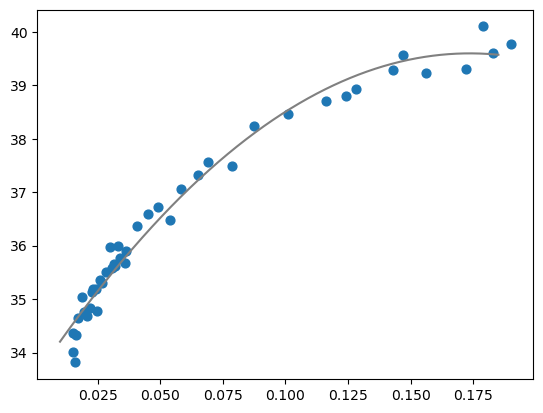

In [185]:
data=np.loadtxt('mu_vs_z.dat')

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Z=data[:,0]
Z=Z.reshape(-1,1)
M=data[:,1]

xfit = np.linspace(0.01, 0.185, 1000).reshape(-1,1)
model1 = PolynomialRegression(2).fit(Z, M)

plt.scatter(Z.flatten(), M, s=40)
plt.plot(xfit.flatten(), model1.predict(xfit), color='gray')

<div class="span alert alert-success">
Follow the example above and perform a 10th-order polynomial fit to our data. You should see a more wiggly curve.

The 10th-order polynomial fit is definitely more accurate since it tries to go through all the data points better than our 2nd-order polynomial fit. But is higher accuracy really helpful?  Towards higher $z$ we see that the 10th-order fit is just twisting itself to go through as many points as possible. In reality we know that the trend we're trying to fit is likely monotonic and smooth. We also know that we don't need to fit through every single data point since every data point has some measurement uncertainty. So we're faced with the following conumdrum:

**If we fit with a low-order polynomial, our fit would not be good since it would miss many data points.** This is called **high bias**.

**If we fit with a high-order  polynomial, our fit would not be good since it would try to artificially wiggle its way through all the points and lose its generalizability.** This is called high **high variance**.

Of course there's a sweet spot in between these two extremes. At what polynomial order do we stop? We can prevent the fitting procedure from seeing all the data by setting aside a **holdout set** (also known as a **validation set**): that is, we hold back some subset of the data from the fitting process, and then use this holdout set to check the model performance. This splitting can be done using the **train_test_split** utility in **Scikit-Learn**.

In [ ]:
from sklearn.model_selection import train_test_split

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(Z, M, random_state=0,
                                  train_size=0.5)

# fit a 2nd-order polynomial model on one set of data
model = PolynomialRegression(2).fit(X1, y1)

# evaluate the model on the second set of validation data
y2_model = model.predict(X2)
error = np.mean((model.predict(X2)-y2)**2)
error

<div class="span alert alert-success">
Write a loop to repeat the process above for increasing orders of polynomial and calculate the error for each. Use a train_size of 80%. Identify where the minimum of the error is – that's where our polynomial fit is best!
</div>